In [62]:
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import json
import numpy as np
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier,ExtraTreesClassifier,RandomForestClassifier,VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [3]:
colnames=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'salary'] 
data = pd.read_csv('data/adult.data',header=None,names=colnames)
data['salary_target'] = 0
data.loc[data['salary'] == ' >50K', 'salary_target'] = 1
data = data.drop('salary',axis = 1)

In [4]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary_target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [5]:
data.info() # This shows there is no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  salary_target   32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


In [6]:
data.shape

(32561, 15)

In [7]:
data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,salary_target
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456,0.240810
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429,0.427581
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


### Exploratory Data Analysis

In [8]:
# define numerical & categorical columns
numeric_features = [feature for feature in data.columns if data[feature].dtype != 'O']
categorical_features = [feature for feature in data.columns if data[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 7 numerical features : ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'salary_target']

We have 8 categorical features : ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


### Feature information

age: continuous.
workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
fnlwgt: continuous.
education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
education-num: continuous.
marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
sex: Female, Male.
capital-gain: continuous.
capital-loss: continuous.
hours-per-week: continuous.
native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

### Univeriate Analysis

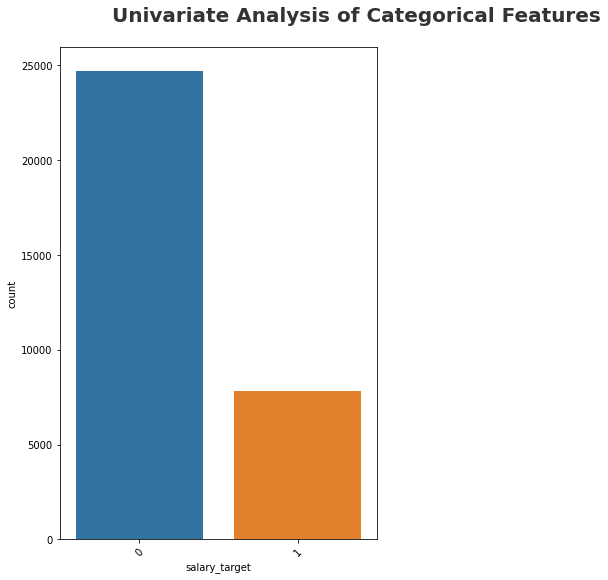

In [9]:
# categorical columns
plt.figure(figsize=(10, 15))
plt.suptitle('Univariate Analysis of Categorical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)
cat1 = [ 'salary_target',]
for i in range(0, len(cat1)):
    plt.subplot(2, 2, i+1)
    sns.countplot(x=data[cat1[i]])
    plt.xlabel(cat1[i])
    plt.xticks(rotation=45)
    plt.tight_layout()

#### Observation:
From the above plot we can say that the data is imbalanced, so we must peform some kind of sampling to balance the data

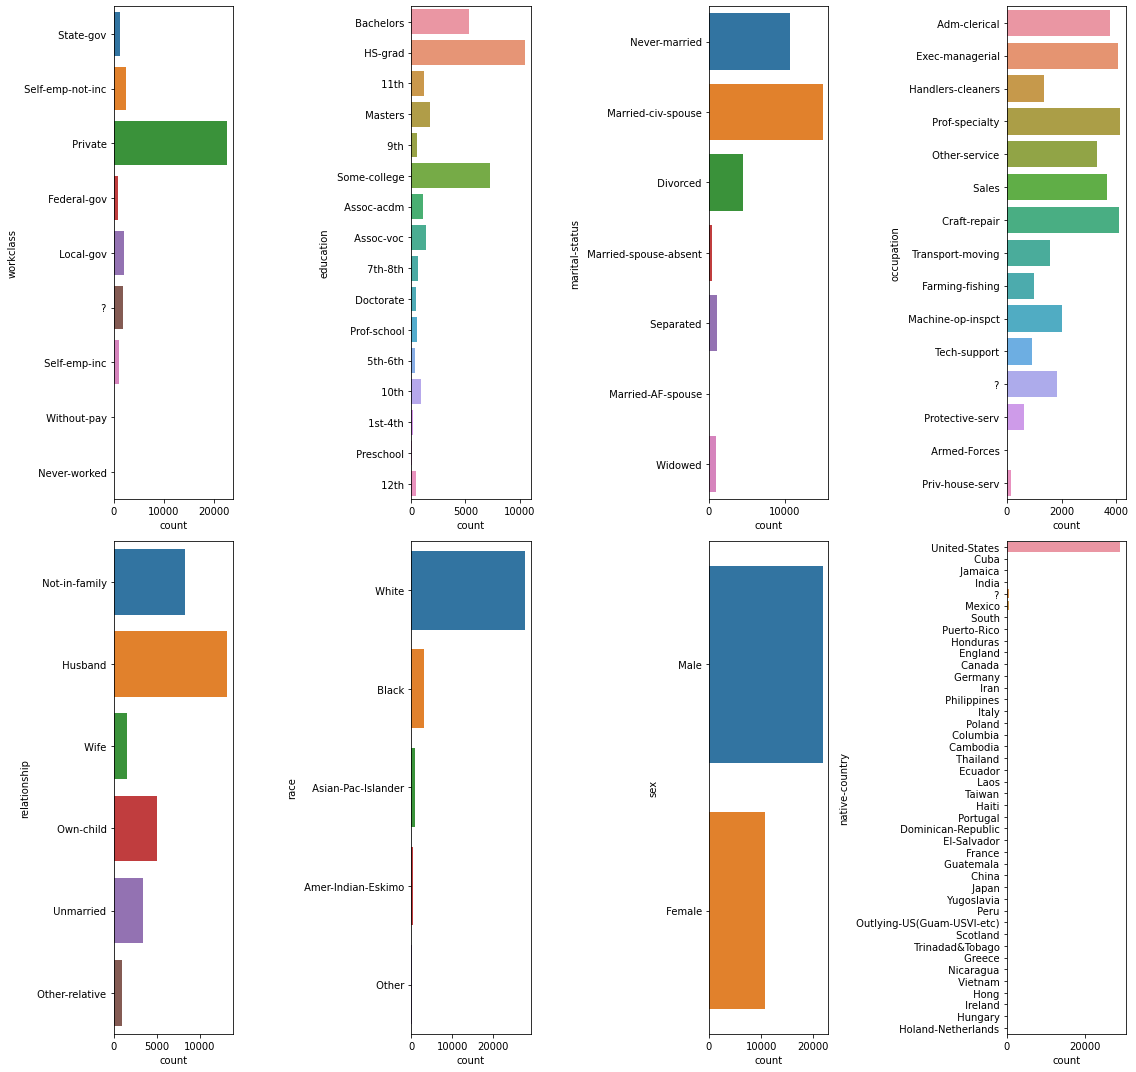

In [10]:
# Dropping the fnlwgt column
fig, axes = plt.subplots(2,4, figsize=(16,15))
row = 0
column = 0

for i, feature in enumerate(data.select_dtypes(include='object')):
    sns.countplot(y=feature, data=data,ax= axes[row][column])
    if column == 3:
        column = 0
        row += 1
    else:
        column +=1
fig.tight_layout()
plt.show()

#### Observations:
We can see the native-country in highly right skewed. And it doesn't contribute much to target varibale. So we will be dropping this feature mostly.

Even the race is have similar kind of data distribution but that won't be a bigger problem

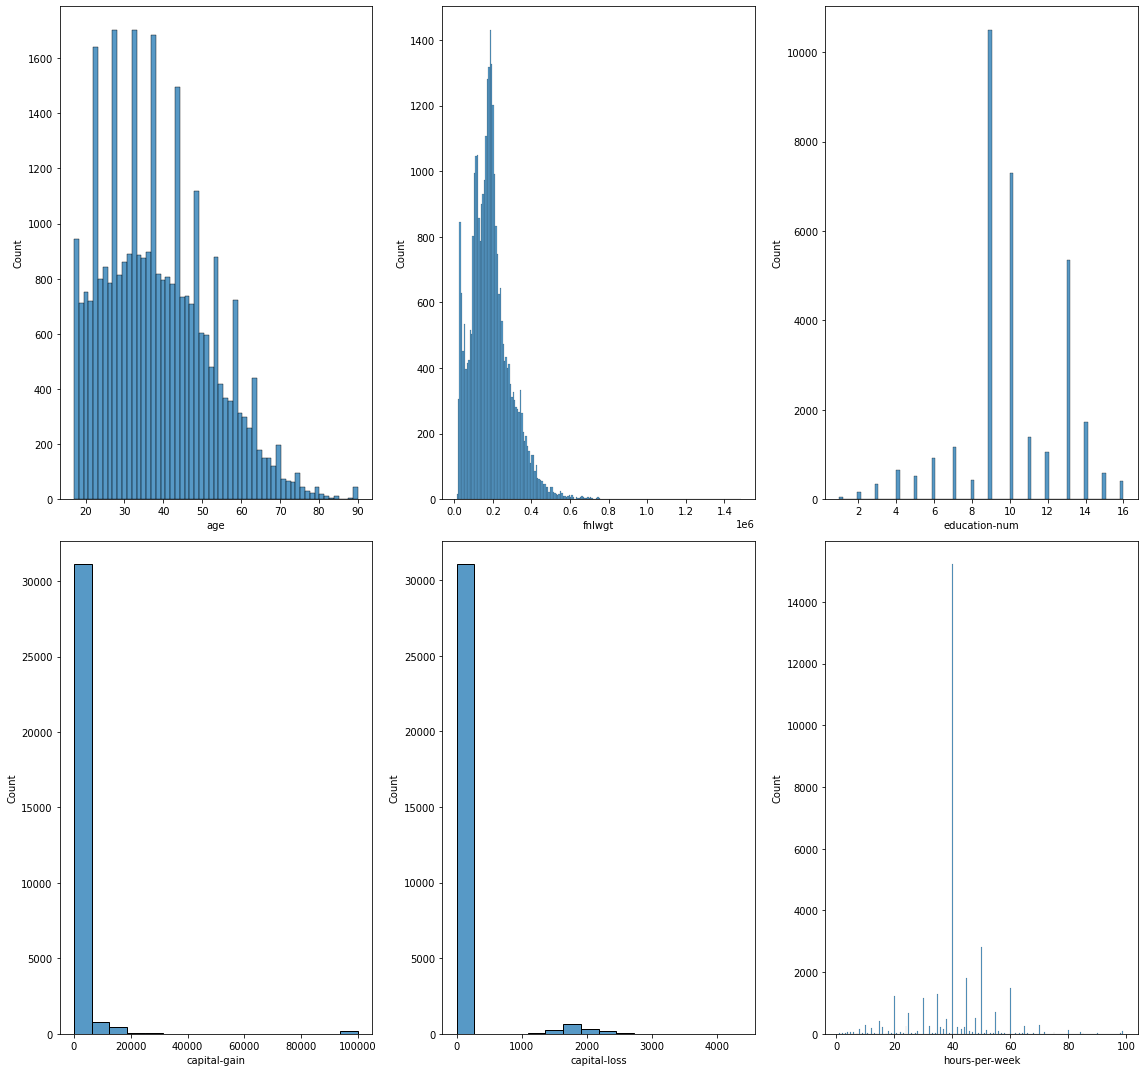

In [11]:
fig, axes = plt.subplots(2,3, figsize=(16,15))
row = 0
column = 0

for i, feature in enumerate(data.select_dtypes(include=['int', 'float'])):
    sns.histplot(x=feature, data=data,ax= axes[row][column])
    if column == 2:
        column = 0
        row = 1
    else:
        column +=1
fig.tight_layout()
plt.show()

#### Observation:
1) We have captial gain and captial loss the kind of distribution, we can check the corillation of the two features and combine it into a single feature

2) fnlwgt(In other words, this is the number of people the census believes the entry represents). I think this feature won't contribute much to the target variable so we can drop it

3) The age varibale is rightly skewed

<AxesSubplot:xlabel='hours-per-week'>

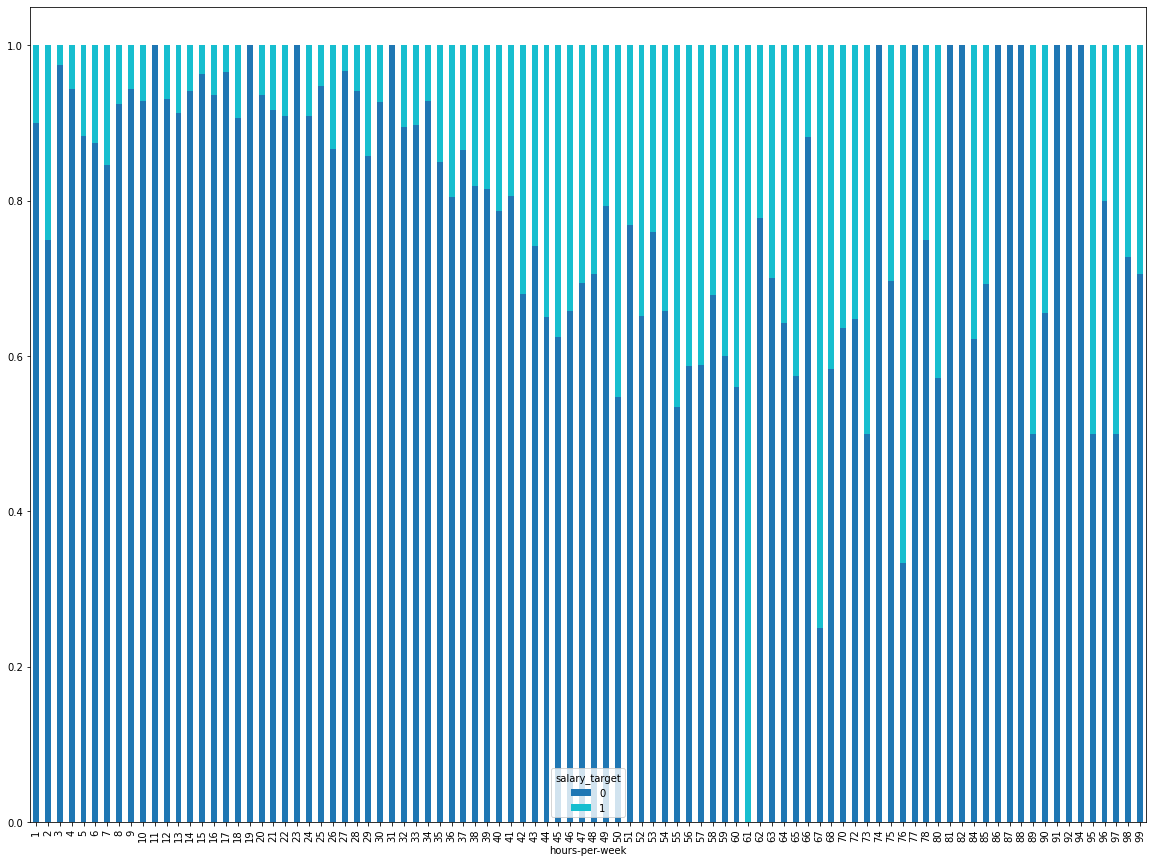

In [12]:
# Closer look into hours.per.week

df_sub = pd.crosstab(index=data['hours-per-week'],
                    columns=data['salary_target'],
                    normalize="index")
df_sub.plot(kind='bar', 
                stacked=True, 
                colormap='tab10', figsize=(20,15))


#### Observation:
1) Even though in some case the number of working hours increases the probabily of getting >50 income is not getting increased.

2) We can see that people from mean to Q3 have the high probabilty of getting >50 income

### Bivariate analysis

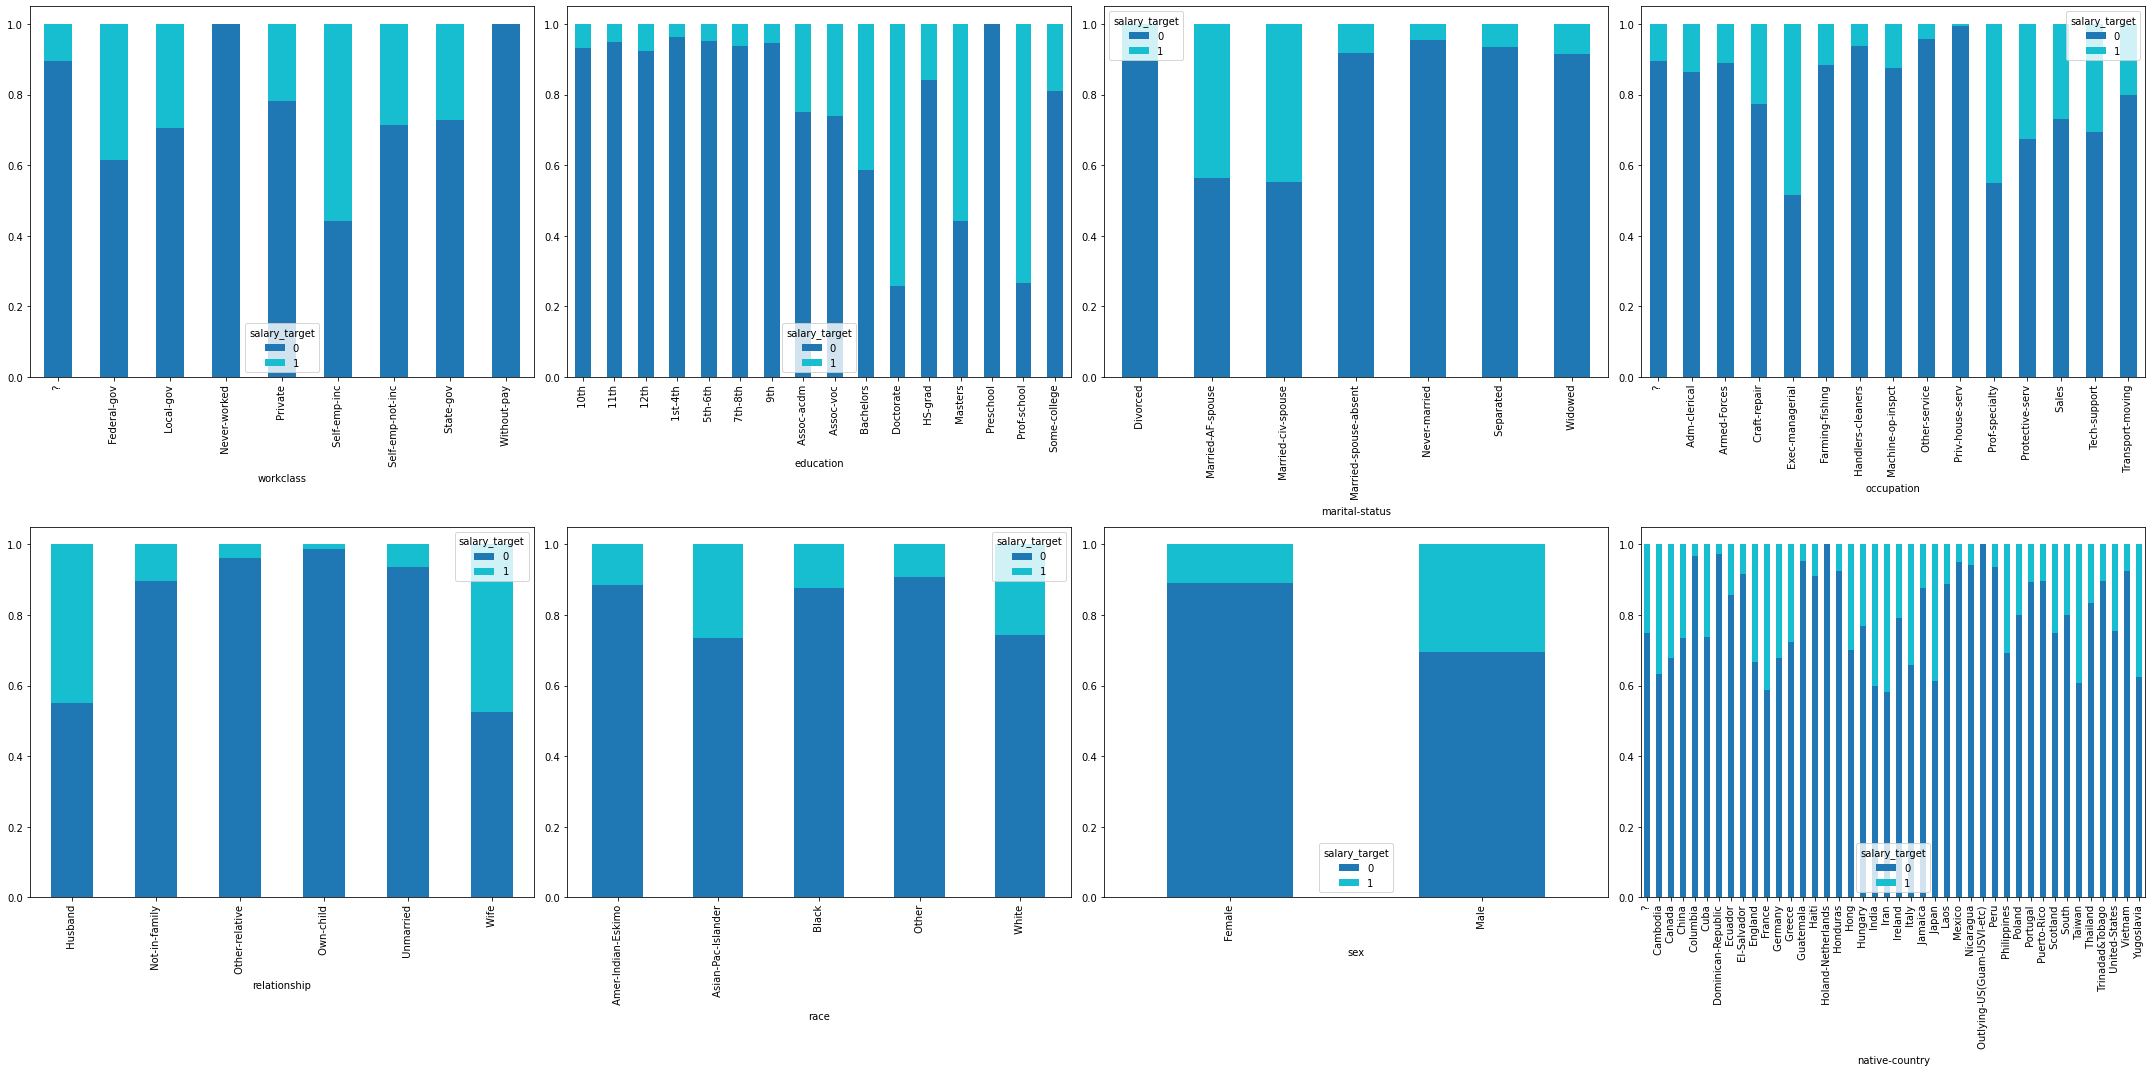

In [13]:
fig, axes = plt.subplots(2,4, figsize=(30,15))
row = 0
column = 0

for i, feature in enumerate(data.select_dtypes(include='object')):
    df_sub = pd.crosstab(index=data[feature],
                        columns=data['salary_target'],
                        normalize="index")
    df_sub.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', ax=axes[row][column])
    if column == 3:
        column = 0
        row += 1
    else:
        column +=1
fig.tight_layout()
plt.show()

#### Observation:
1) We can see that person in kind of married status has high changes of making income >50, so we can combine relationship and martial-status

2) Sepcific type of education, workclass and occupation have high chance of getting income >50

3) We can also do some anlysis on native-country checking if specific type of people in native-country getting income > 50

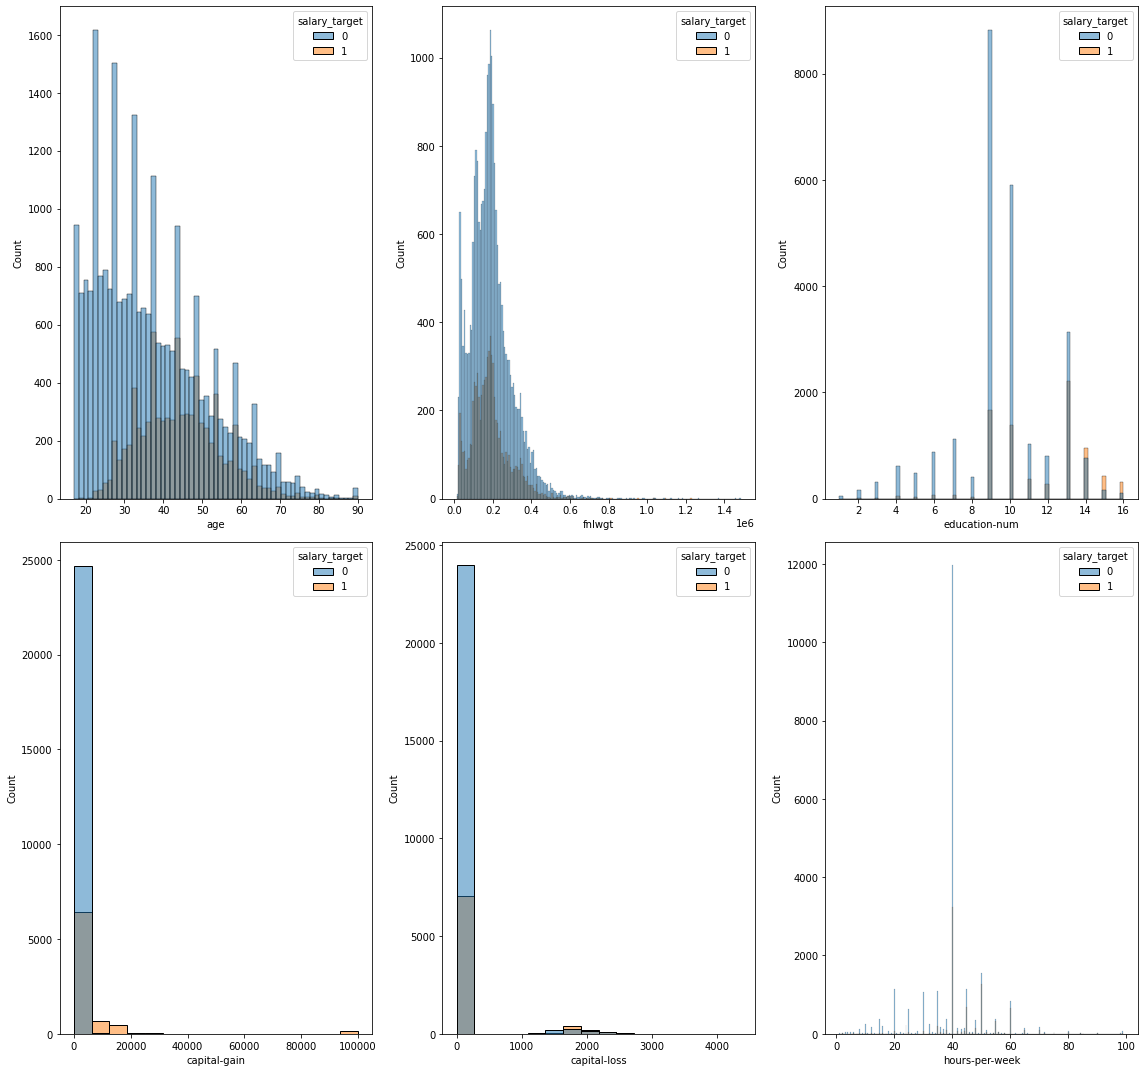

In [14]:
fig, axes = plt.subplots(2,3, figsize=(16,15))
row = 0
column = 0

for i, feature in enumerate(data.select_dtypes(include=['int', 'float'])):
    sns.histplot(x=feature, data=data,ax= axes[row][column], hue='salary_target')
    if column == 2:
        column = 0
        row = 1
    else:
        column +=1
fig.tight_layout()
plt.show()

#### Observations:
1) Although the age variable is right-skewed, but when we dive deeper through the income variable, we can see that the >50K income group follow a different age distribution 

2) Individual with higher education level tends to become to the higher income group. 

3) Individual with positive capital gain tends to belong to the higher income group

### Multivariate analysis

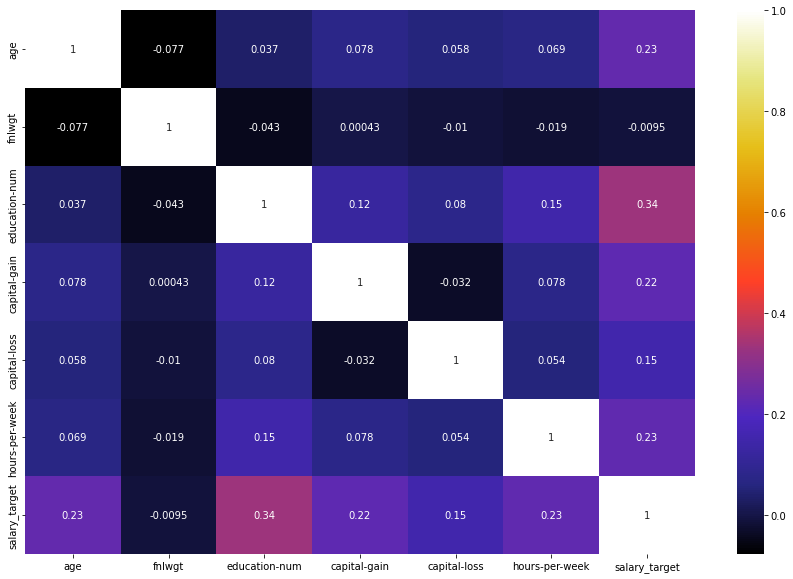

In [15]:
plt.figure(figsize = (15,10))
sns.heatmap(data.corr(), cmap="CMRmap", annot=True)
plt.show()

### Observation:
1) As we can see fnlwgt has very less corillation we will drop it.

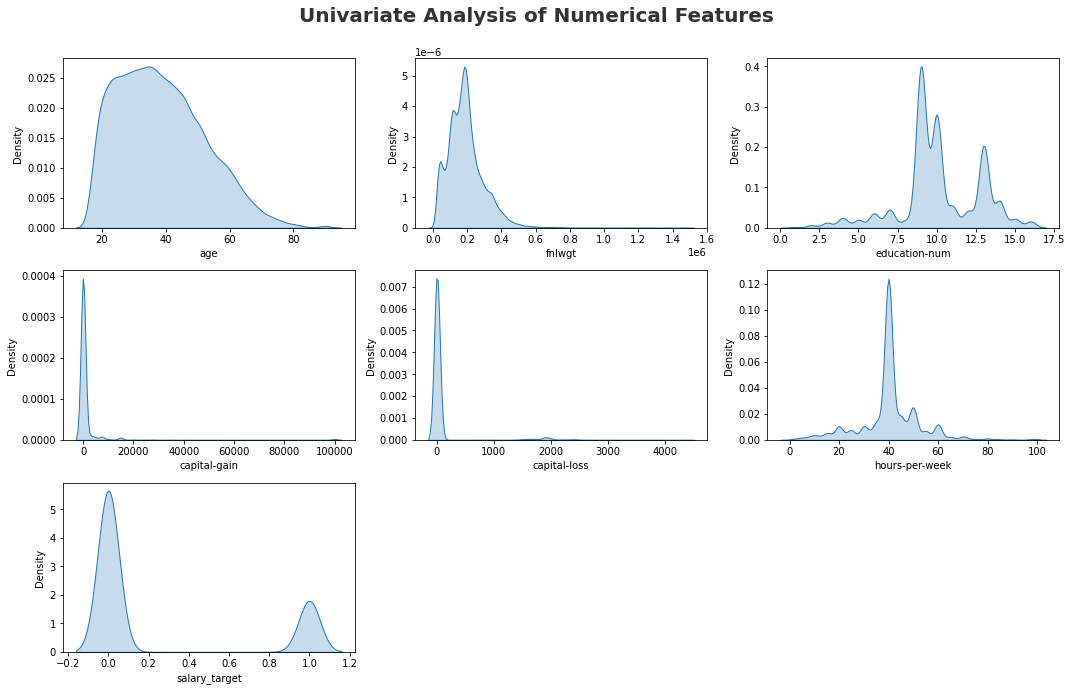

In [16]:
plt.figure(figsize=(15, 15))
plt.suptitle('Univariate Analysis of Numerical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(0, len(numeric_features)):
    plt.subplot(5, 3, i+1)
    sns.kdeplot(x=data[numeric_features[i]],fill=True,palette="crest")
    plt.xlabel(numeric_features[i])
    plt.tight_layout()

Num of continues features : ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


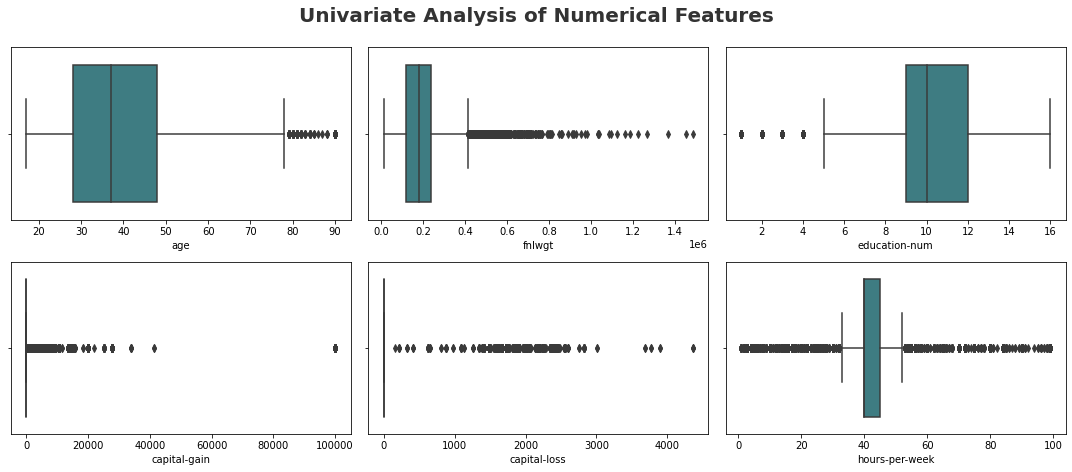

In [17]:
continues_features=[feature for feature in numeric_features if len(data[feature].unique())>=10]
print('Num of continues features :',continues_features)

plt.figure(figsize=(15, 15))
plt.suptitle('Univariate Analysis of Numerical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(0, len(continues_features)):
    plt.subplot(5, 3, i+1)
    sns.boxplot(x=data[continues_features[i]],palette="crest")
    plt.xlabel(numeric_features[i])
    plt.tight_layout()

### Feature Engineeting

In [18]:
data['capital.income'] = data['capital-gain'] - data['capital-loss']
data['is_married'] = data['marital-status'].apply(lambda status: 1 if (status == " Married-civ-spouse" or status == ' Married-AF-spouse') else 0 )
data['husband_or_wife'] = data['relationship'].apply(lambda status: 1 if (status == " Husband" or status == ' Wife') else 0 )
data['sex'] = data['sex'].apply(lambda sex: 1 if sex == " Male" else 0 )

In [19]:
data.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'salary_target', 'capital.income', 'is_married', 'husband_or_wife'],
      dtype='object')

In [20]:
data_model = data.copy()
data_model = data_model.drop(['fnlwgt','native-country','education', 'capital-gain','capital-loss','marital-status','relationship'], axis=1)

In [21]:
data_model.shape

(32561, 11)

In [22]:
data_model.head()

,age,workclass,education-num,occupation,race,sex,hours-per-week,salary_target,capital.income,is_married,husband_or_wife
0,39,State-gov,13,Adm-clerical,White,1,40,0,2174,0,0
1,50,Self-emp-not-inc,13,Exec-managerial,White,1,13,0,0,1,1
2,38,Private,9,Handlers-cleaners,White,1,40,0,0,0,0
3,53,Private,7,Handlers-cleaners,Black,1,40,0,0,1,1
4,28,Private,13,Prof-specialty,Black,0,40,0,0,1,1


In [36]:
data_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              32561 non-null  int64 
 1   workclass        32561 non-null  object
 2   education-num    32561 non-null  int64 
 3   occupation       32561 non-null  object
 4   race             32561 non-null  object
 5   sex              32561 non-null  int64 
 6   hours-per-week   32561 non-null  int64 
 7   salary_target    32561 non-null  int64 
 8   capital.income   32561 non-null  int64 
 9   is_married       32561 non-null  int64 
 10  husband_or_wife  32561 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 2.7+ MB


In [24]:
data_model_copy = data_model.copy()

In [25]:
X = data_model_copy.drop('salary_target',axis=1)
y = data_model_copy['salary_target']

In [26]:
# algo to be implemented
# 1) bagging classifier 
# 2) extra tree classifier 
# 3) random forest classifier 
# 4) voting classifier 

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

print("Train: ",X_train.shape, y_train.shape)
print("Test: ",X_test.shape, y_test.shape)

Train:  (22792, 10) (22792,)
Test:  (9769, 10) (9769,)


In [41]:
preprocessor = ColumnTransformer(
                transformers=[
                    ("num", StandardScaler(), X_train.select_dtypes(['int','float']).columns),
                    ("cat", OneHotEncoder(handle_unknown="ignore"),
                     X_train.select_dtypes('object').columns),
                ])
clf = Pipeline(steps=[('preprocessor', preprocessor)])
X_train_trans = clf.fit_transform(X_train)

trans_col = clf.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out()
trans_col = list(X_train.select_dtypes(['int','float']).columns) + list(trans_col)

X_train_trans = pd.DataFrame.sparse.from_spmatrix(X_train_trans,
                                                     columns=list(trans_col))

X_test_trans = clf.transform(X_test)
X_test_trans = pd.DataFrame.sparse.from_spmatrix(X_test_trans,
                                                     columns=list(trans_col))

### Bagging

In [48]:
bagging_clf = BaggingClassifier(base_estimator=SVC(),n_estimators=10, random_state=0).fit(X_train_trans, y_train)

In [49]:
y_predict_bagging = bagging_clf.predict(X_test_trans)

In [50]:
accuracy_score(y_test,y_predict_bagging)

0.8553587880028662

### Extraforest

In [52]:
extra_clf = ExtraTreesClassifier(n_estimators=100, random_state=0).fit(X_train_trans, y_train)

In [53]:
y_predict_extra = bagging_clf.predict(X_test_trans)
print(accuracy_score(y_test,y_predict_extra))

0.8553587880028662


### Random forest

In [58]:
random_clf = RandomForestClassifier(max_depth=2, random_state=0).fit(X_train_trans, y_train)

In [59]:
y_predict_random = random_clf.predict(X_test_trans)
print(accuracy_score(y_test,y_predict_random))

0.7893336063056607


### voting

In [67]:
clf1 = LogisticRegression()
clf2 = RandomForestClassifier()
clf3 = SVC()

In [72]:
voting_clf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('svc', clf3)], voting='hard')

In [88]:
data_model_voting = data_model_copy.copy()

In [89]:
one_hot = pd.get_dummies(data_model_voting[['workclass','occupation','race']])
data_model_voting = data_model_voting.drop('workclass',axis = 1)
data_model_voting = data_model_voting.drop('occupation',axis = 1)
data_model_voting = data_model_voting.drop('race',axis = 1)
data_model_voting = data_model_voting.join(one_hot)


In [90]:
data_model_voting.head()

,age,education-num,sex,hours-per-week,salary_target,capital.income,is_married,husband_or_wife,workclass_ ?,workclass_ Federal-gov,...,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White
0,39,13,1,40,0,2174,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,50,13,1,13,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,38,9,1,40,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,53,7,1,40,0,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,13,0,40,0,0,1,1,0,0,...,1,0,0,0,0,0,0,1,0,0


In [94]:
X = data_model_voting.drop('salary_target',axis=1)
y = data_model_voting['salary_target']

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

print("Train: ",X_train.shape, y_train.shape)
print("Test: ",X_test.shape, y_test.shape)

Train:  (22792, 36) (22792,)
Test:  (9769, 36) (9769,)


In [96]:
scaler=StandardScaler()
X_train_trans=scaler.fit_transform(X_train)
X_test_trans=scaler.transform(X_test)

In [97]:
voting_clf.fit(X_train_trans,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [98]:
y_predict_voting = voting_clf.predict(X_test_trans)
print(accuracy_score(y_test,y_predict_voting))

0.8552564233800799
